# COMP24112 - Exercise 3: _Face Recognition_ (25 Marks)

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

You will be marked for your code presentation, design, results, and report. Please note this notebook should take no more than 10 minutes to run on lab computers. 

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [70]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt


Now you can load the data:

In [71]:
data, labels = load_data()

### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

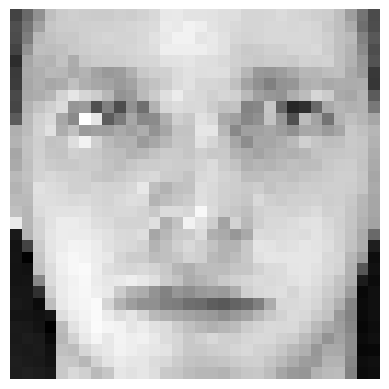

In [72]:
# Display a single example.
show_single_face(data[0, :])

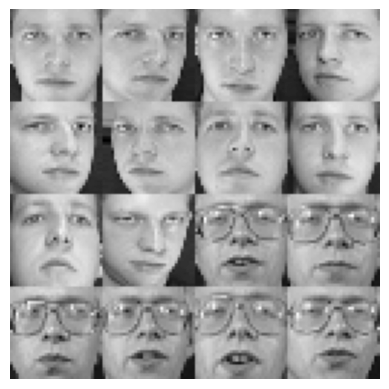

In [73]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [74]:
# normalization
data = data / 255

# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares (5 marks, Normal)
### 3.1 Implementation
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ (lambda) as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [75]:
def l2_rls_train(data, labels, p
                 ): # Add any other arguments here
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"
    lmbd: type and description of "lmbd"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    n, m = X.shape
    X1 = np.ones((n, 1))
    X_tilde = np.append(X1, X, axis = 1)
    
    # Compute the coefficient vector.
    X_transpose = X_tilde.transpose()
    s, r = X_tilde.shape
    # Calculate psuedo inverse when hyperparameter is 0, otherwise use the normal formula with inverse
    if p == 0:
        w = np.linalg.pinv(X_tilde) @ y
    else:
        w = np.linalg.inv(X_transpose @ X_tilde + p * np.identity(r)) @ X_transpose @ y
   
    
    # Return model parameters.
    return w

Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [76]:
def l2_rls_predict(w, data):
    """
    A summary of your function goes here.

    data: type and description of "data"
    w: type and description of "w"

    Returns: type and description of the returned variable(s).
    """
    # This is just to be consistent with the lecture notes.
    X = data
    
    # Expands X with column of 1s
    n, m = X.shape
    X1 = np.ones((n, 1))
    X_tilde = np.append(X1, X, axis = 1)
    
    # Compute the prediction.
    predicted_y = X_tilde @ w
    
     
   
        
    return predicted_y

### 3.2 Report

Explain briefly the knowledge supporting your implementation and your design step by step. Explicitly comment on the role of any arguments you have added to your functions. 

## 4. Face Recognition (4 Marks, Normal)
### 4.1 Implementation and experiment design

Use your implemented functions to perform multi-class classification to identify the subject in each image, for all 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

Table for each lambda value and its corresponding error
Lambda          Error               
1.000e-06       0.2083              
1.000e-05       0.2083              
1.000e-04       0.2083              
1.000e-03       0.2083              
1.000e-02       0.2083              
1.000e-01       0.2083              
0.000e+00       0.2083              
1.000e+00       0.2021              
1.000e+01       0.2000              
1.000e+02       0.2958              
1.000e+03       0.4563              
1.000e+04       0.9479              
1.000e+05       0.9750              
1.000e+06       0.9750              
1.000e+07       0.9750              
1.000e+08       0.9750              
1.000e+09       0.9750              
best_lamda: 10
Confusion matrix:
[[4 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 4]]


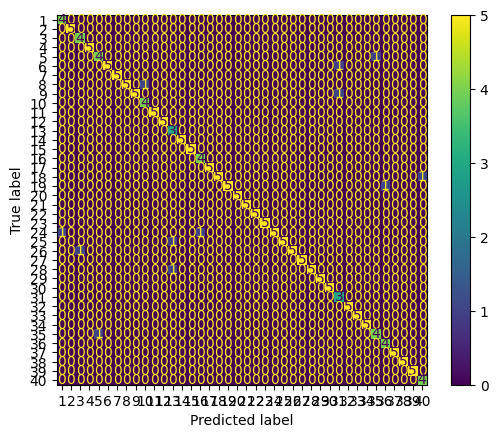

Testing error mean: 0.06
Testing accuracy mean: 0.94


In [77]:
# # Your code goes here
# # Note that you may find it helpful to use one-hot encoding to deal with multi-class labels
# # Keep track of the person with highest error

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Using random subsampling to find best lambda
def hyperparameter_selection(tr_data, tr_label, data_splits):
    lamda_range = []
    for i in range(-6, 10, 1):
        if i == 0:
          lamda_range.append(0)
        lamda_range.append(10**i)
    
    # Creating a list of indices for splitting the data
    ind = []
    for i in range(data_splits):
        ind.append(list(partition_data(tr_label, num_per_class=2)))
    
    # Creating a list of errors for each lambda value
    lamda_errors = []
    for lamda in lamda_range:
        each_errors = []
        for i in range(data_splits):
            tr_data_ = tr_data[ind[i][0], :]
            te_data_ = tr_data[ind[i][1], :]
            te_label_ = tr_label[ind[i][1]]
            err = classify_err(tr_data_, te_data_, lamda, -1, 1, 2, 3, te_label_, 40,False)
            each_errors.append(err)
        lamda_errors.append(np.mean(np.array(each_errors)))
        
    # Finding the lambda value with the lowest error
    best_lambda = lamda_errors.index(min(lamda_errors))
    print('Table for each lambda value and its corresponding error')
    # Printint table for each lambda value and its corresponding error
    print('{:<15} {:<20}'.format('Lambda', 'Error'))
    for i in range(len(lamda_range)):
        print('{:<15.3e} {:<20}'.format(lamda_range[i], '{:.4f}'.format(lamda_errors[i])))
  
    return lamda_range[best_lambda]
from sklearn.metrics import confusion_matrix

# Defining a softmax function for making predictions
def softMax(w, X, predict):
    X_new = np.append(np.array([1]), X)
    exp = np.exp(np.transpose(w) @ X_new)
    softmax = exp[predict - 1] / np.sum(exp)
    return softmax


# Defining a function for creating training labels
def train_label(class1, class2, num_per_class, kinds):
    tr_label = []
    for i in range(kinds):
        for j in range(num_per_class):
            array = [class1 for k in range(kinds)]
            array[i] = class2
            tr_label.append(array)
    tr_label_array = np.array(tr_label)
    return tr_label_array

# Defining a function for calculating the classification error
def classify_err(X, te_data, lamda, a, b, num_per_class_tr, num_per_class_te, truth, kinds, flag):
    tr_labels = train_label(a, b, num_per_class_tr, 40)

    w = l2_rls_train(X, tr_labels, lamda)

    predictedY = l2_rls_predict(w, te_data)

    lb_out = []
    total_pic = 40 * num_per_class_te
    for j in range(total_pic):
        prob = []  # fixed syntax error
        for i in range(kinds):
            prob.append(softMax(w, te_data[j,:], i+1))
        max_prob = max(prob)

        result = prob.index(max_prob) + 1
        lb_out.append(result)

    ans = np.array(lb_out)

    err = (ans != truth)
    image_err = []
    err_mean = 0
    for i in range(40):
        tmp = 0
        for j in range(num_per_class_te):
            if err[j + i * num_per_class_te]:
                tmp += 1
                err_mean += 1
        image_err.append(tmp/num_per_class_te)
    if flag:
        conf_matrix = confusion_matrix(ans, truth)
        print("Confusion matrix:")
        print(confusion_matrix(ans, truth))
        return image_err, conf_matrix,err_mean / total_pic
    return err_mean / total_pic 

tr_ind, te_ind = partition_data(labels, num_per_class=5)
tr_label = labels[tr_ind]
tr_data = data[tr_ind, :]
te_data = data[te_ind, :]
te_label = labels[te_ind]

best_lamda = hyperparameter_selection(tr_data, tr_label, 4)
print('best_lamda:', best_lamda)


image_err,conf_matrix,err = classify_err(tr_data, te_data, best_lamda, -1, 1, 5, 5, te_label, 40, True)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(1,41))
cm_display.plot()
plt.show()
print('Testing error mean:', err)
print('Testing accuracy mean:', 1-err)



 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

Displaying the first 20 good images in a 5x4 grid:


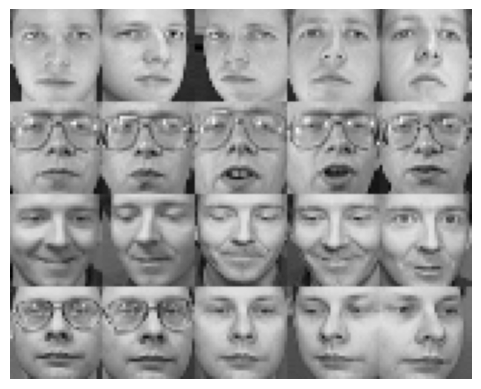

In [78]:
# Prints out the easiest faces
# computeing the indices of correctly classified images that were classified with a high confidence
good_index = [j+i*5 for i,arr in enumerate(conf_matrix) if arr[np.argmax(arr)] > 3 for j in range(5)]
print("Displaying the first 20 good images in a 5x4 grid:")
show_faces(te_data[good_index[:20], :], num_per_row=5)
good_images = [te_data[good_index[:20], :]]


 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

Displaying the Bad Images:


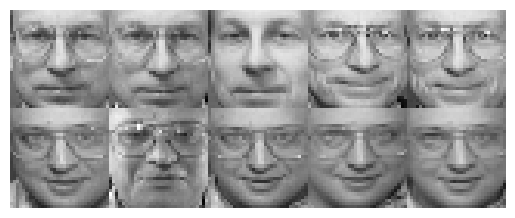

In [79]:
# Prints out the worst faces 
bad_index = [j + i*5 for i, arr in enumerate(conf_matrix) if arr[np.argmax(arr)] < 4 for j in range(5)]
print("Displaying the Bad Images:")
show_faces(te_data[bad_index, :], num_per_row=5)


### 4.2 Report

Explain the classification steps, and report your chosen hyper-parameter and results on the test set. Did you notice any common features among the easiest and most difficult subjects to classify? Describe your observations and analyse your results.

## 5. Face Completion (4 Marks, Normal)
In this task you will predict the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [80]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

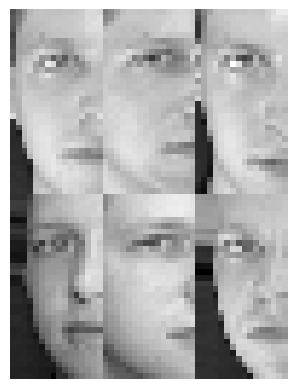

In [81]:
show_split_faces(left[:6, :], num_per_row=3)

### 5.1 Implementation and experiment design

Build a face completion model using your regularised least squares model. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error (MAPE) to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [82]:
# Your code goes here


def face_completion(ind):
    
    # Map the labels and partition the data
    tr_ind, te_ind = partition_data(labels, num_per_class = 5)
    tr_data = data[tr_ind, :]
    tr_label = labels[tr_ind]
    te_data = data[te_ind, :]
    te_label = labels[te_ind]

    # Splits the training and testing data into left and right
    left_tr, right_tr = split_left_right(tr_data)
    left_te, right_te = split_left_right(te_data)

    # Train with the left and right from the training data
    w = l2_rls_train(left_tr, right_tr, 0)

    # Predict the right side of the face by inputing the left testing data
    predicted_right_te = l2_rls_predict(w, left_te)

    # Generate the original pic along with the predicted (right side) for the specific indices given
    original_pic = join_left_right(left_te[ind], right_te[ind])
    predicted_pic = join_left_right(left_te[ind], predicted_right_te[ind])

    # Calculate the mean absolute error
    n,m = predicted_right_te.shape
    mean = 0

    mean1 = (abs(right_te - predicted_right_te) / abs(right_te))
    mean2 = np.mean(mean1)
    
    for i in range(n):
        for j in range(m):
            mean = mean + (abs(right_te[i][j] - predicted_right_te[i][j]) / abs(right_te[i][j]))
    mean_err = (1/(m*n)) * mean   
    
    print("The mean error is: ", str(mean_err))
    print("First row represents Original Images while second row represents Predicted Images")
    show_faces(original_pic, num_per_row=3)
    show_faces(predicted_pic, num_per_row=3)


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

The mean error is:  0.2315770820355809
First row represents Original Images while second row represents Predicted Images


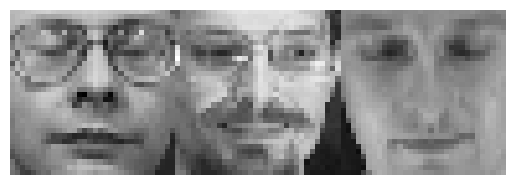

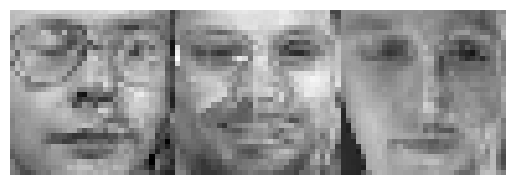

In [83]:
# Your code goes here
ind = np.random.choice(200, 3)
face_completion(ind)

    


### 5.2 Report

Report the MAPE and make some observations regarding the results of the face completion model. How well has your model performed? Offer one suggestion for how it can be improved.


## 6. Training linear least squares model via gradient descent (5 marks, Normal)
For these experiments you will be performing **binary classification.** 
### 6.1 GD Implementation
Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [84]:
def lls_gd_train(data, labels, learning_rate, N):
    """
    A summary of your function goes here.

    data: array which store the training data in the form of matrix. Each row of the matrix
    can be transformed to a face through show_single_face function.
    labels: array which store the class that the training data belongs to in the form of matrix. label[i, :] stores the 
    class of data[i, :].
    
    Returns: 2 array. The first stores the cost of each iteration and the second store the weight vector of each iteration.
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    ncol = len(data)
    X_tilde = np.hstack((np.ones((ncol, 1), dtype=int), data))
    
    # Weight initialization
    w = np.zeros(1025)
    
    # GD update of weights
    cost_all = []
    w_all = []
    for i in range(N):
        
        # cost and gradient descent of the linear least squares model
        gd = X_tilde.T @ X_tilde @ w - X_tilde.T @ y
        cost = 0.5 * np.sum((w @ X_tilde.T - y)**(2))
        
        # Weight update
        w = w - learning_rate * gd
        
        # save w and cost of each iteration in w_all and cost_all
        w_all.append(w)
        cost_all.append(cost)
    
    # Return model parameters.
    return cost_all, w_all


### 6.2 Experiments

Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it runs. 

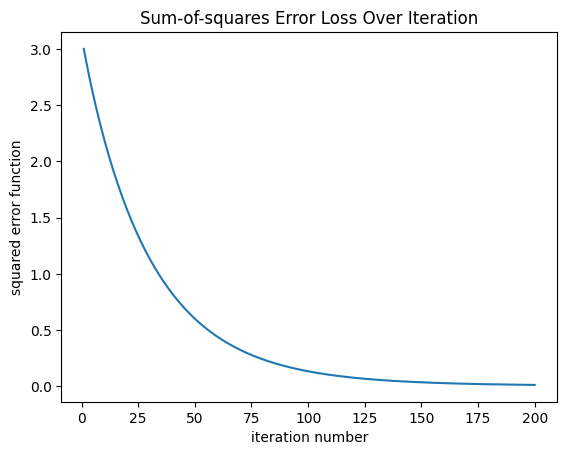

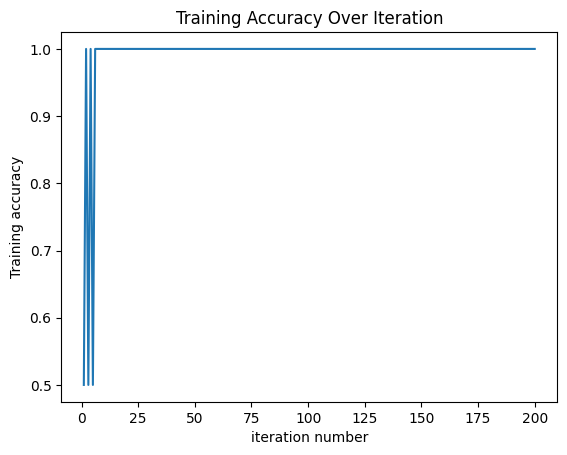

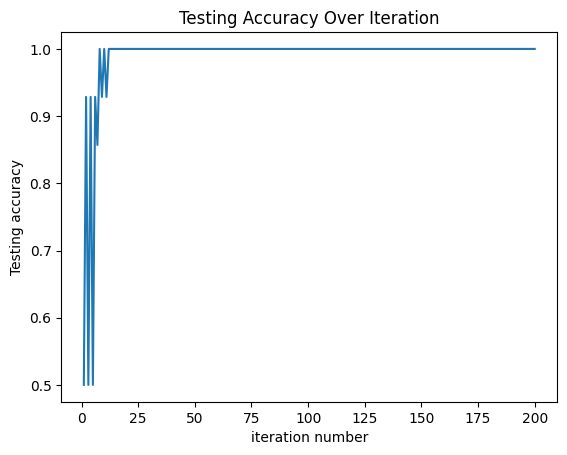

In [85]:
#  Your code goes here

def split_data(data):
    tr_ind, te_ind = partition_data(labels, num_per_class=3)
    tr_data = data[tr_ind, :]
    tr_label = labels[tr_ind]
    te_data = data[te_ind, :]
    te_label = labels[te_ind]
    return tr_data, tr_label, te_data, te_label
    
# selecting only the samples whose labels are 1 or 30, and returning these as the new training and testing sets.
def one_thirty_gd(data):
    tr_data, tr_label, te_data, te_label = split_data(data)  
    tr_data2 = tr_data[np.where((tr_label==1) | (tr_label==30))]
    te_data2 = te_data[np.where((te_label==1) | (te_label==30))]
    return tr_data2, te_data2

tr_data2, te_data2 = one_thirty_gd(data)
# Create -1,1 labels for the new training and test datasets
tr_label2 = [1,1,1,-1,-1,-1]
te_label2 = [1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1]
learning_rate = 10**(-3)
loop = 200
cost_all, w_all = lls_gd_train(tr_data2, tr_label2, learning_rate, loop)

# Comparing the predicted labels to the actual labels to calculate the accuracy of the predictions.
def predictgd(w, te_data2, te_label2):
    correct = 0
    y = l2_rls_predict(w, te_data2)
    for i in range(len(y)):
        if y[i] < 0:
            y[i] = -1
        else:
            y[i] = 1
        if y[i] == te_label2[i]:
            correct += 1
    len_te_label2 = len(te_label2)
    accuracy = correct / len_te_label2
    return accuracy

# The change of  sum-of-squares error loss that we minimise (1st graph)
datum = np.arange(1, 201, 1)
plt.plot(datum, cost_all, label='')
plt.xlabel('iteration number')
plt.ylabel('squared error function')
plt.title('Sum-of-squares Error Loss Over Iteration')
plt.show()

# the change of the classification accuracy for training samples over iterations (2nd graph)
accuracy_list_train = []
for i in w_all:
    accuracy = predictgd(i, tr_data2, tr_label2)
    accuracy_list_train.append(accuracy)

datum = np.arange(1, 201, 1)
plt.plot(datum, accuracy_list_train, label='')
plt.xlabel('iteration number')
plt.ylabel('Training accuracy')
plt.title('Training Accuracy Over Iteration')
plt.show()

# the change of the classification accuracy for test samples over iterations (3rd graph)
accuracy_list_test = []
for i in w_all:
    accuracy = predictgd(i, te_data2, te_label2)
    accuracy_list_test.append(accuracy)

datum = np.arange(1, 201, 1)
plt.plot(datum, accuracy_list_test, label='')
plt.xlabel('iteration number')
plt.ylabel('Testing accuracy')
plt.title('Testing Accuracy Over Iteration')
plt.show()


Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it runs. 

<ipython-input-84-7dfeef62f02d>:30: RuntimeWarning: overflow encountered in square
  cost = 0.5 * np.sum((w @ X_tilde.T - y)**(2))


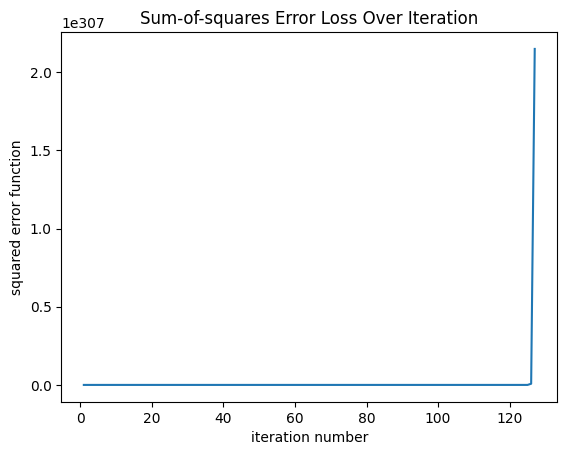

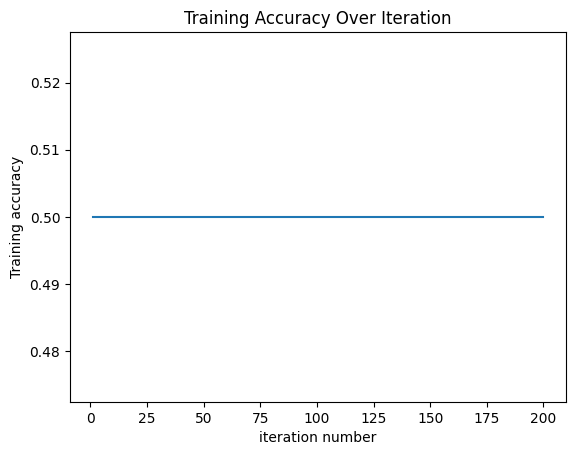

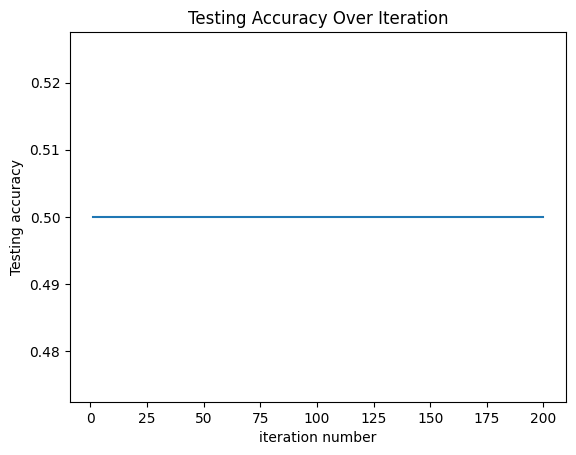

In [86]:
def one_thirty_gd(data):
    tr_data, tr_label, te_data, te_label = split_data(data)  
    tr_data2 = tr_data[np.where((tr_label==1) | (tr_label==30))]
    te_data2 = te_data[np.where((te_label==1) | (te_label==30))]
    return tr_data2, te_data2
# This function takes a weight vector, test data and labels as input, computes the prediction and returns the test error
def predictgd(w, te_data2, te_label2):
    correct = 0
    y = l2_rls_predict(w, te_data2)
    for i in range(len(y)):
        if y[i] < 0:
            y[i] = -1
        else:
            y[i] = 1
        if y[i] == te_label2[i]:
            correct += 1
    len_te_label2 = len(te_label2)
    error = (len_te_label2 - correct)/len_te_label2
    return error

# Calling the one_thirty_gd function to get new training and test datasets
tr_data2, te_data2 = one_thirty_gd(data)
# Create -1,1 labels for the new training and test datasets
tr_label2 = [1,1,1,-1,-1,-1]
te_label2 = [1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1]
learning_rate = 10**(-2)
loop = 200
# Calling the lls_gd_train function to train a weight vector using the new training dataset
cost_all, w_all = lls_gd_train(tr_data2, tr_label2, learning_rate, loop)

# The change of your sum-of-squares error loss that you minimise (1st graph)
datum = np.arange(1, 201, 1)
plt.plot(datum, cost_all,label='')
plt.xlabel('iteration number')
plt.ylabel('squared error function')
plt.title('Sum-of-squares Error Loss Over Iteration')
 
plt.show()
# the change of the classification accuracy for training samples over iterations
accuracyListGdTrain = []
for i in w_all:
    error = predictgd(i, tr_data2, tr_label2)
    accuracy = 1 - error
    accuracyListGdTrain.append(accuracy)

datum = np.arange(1, 201, 1)
plt.plot(datum, accuracyListGdTrain,label='')
plt.xlabel('iteration number')
plt.ylabel('Training accuracy')
plt.title('Training Accuracy Over Iteration')
 
plt.show()

# the change of the classification accuracy for test samples over iterations
accuracyListGdTest = []
for i in w_all:
    error = predictgd(i, te_data2, te_label2)
    accuracy = 1 - error
    accuracyListGdTest.append(accuracy)

datum = np.arange(1, 201, 1)
plt.plot(datum, accuracyListGdTest,label='')
plt.xlabel('iteration number')
plt.ylabel('Testing accuracy')
plt.title('Testing Accuracy Over Iteration')
 
plt.show()




### 6.3 Report

How did you choose the learning rate and iteration number? Explain your results.

## 7. Advanced Gradient-based Training
For this section, you may choose to implement **either Option 1: SGD** (4 marks), or **Option 2: GD with hinge loss** (7 marks). 

*Please note: Option 1 is easier, but gives fewer potential marks. Option 2 is designed to be a steep challenge, potentially involves mathematical derivations not shown in your notes, and will be marked rigorously. Choose wisely!*

### Option 1: Compare with stochastic gradient descent training (4 marks, Normal)
### 7.1 SGD Implementation 
Replace the gradient descent approach that you did in Section 4 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt a similar implementation template to that of your `lls_gd_train` function.

In [87]:
def lls_sgd_train(data, labels, N, eta):
    """
    Trains a linear model by minimizing the sum of squares loss
    using stochastic gradient descent.

    data: A numpy array of shape (N, D) containing the input data.
    labels: A numpy array of shape (N,) containing the target data.
    N: An integer representing the number of iterations to run.
    eta: A float representing the learning rate.

    Returns:
    cost_all: A numpy array of shape (N,) containing the cost at each iteration.
    w_all: A numpy array of shape (D,) containing the learned weights.
    """

    # This is just to be consistent with the lecture notes.
    X, y = data, labels

    # Expand X with a column of ones.
    X_tilde = np.hstack((np.ones((X.shape[0], 1)), X))

    # Weight initialization
    w = np.zeros(X_tilde.shape[1])

    # Initialise arrays to store weights and cost at each iteration
    w_all = np.zeros((N, X_tilde.shape[1]))
    cost_all = np.zeros(N)

    # SGD update of weights

    for i in range(N):

        # Pick single random training sample 
        rand_idx = np.random.randint(X_tilde.shape[0])
        x_i, y_i = X_tilde[rand_idx:rand_idx+1, :], y[rand_idx:rand_idx+1]

        # Compute the cost and gradient of the linear least squares model
        y_pred = np.dot(x_i, w)
        error = y_pred - y_i
        cost = np.sum(error**2) / 2
        s_grad = np.dot(np.dot(x_i.T, x_i), w) - np.dot(x_i.T, y_i)


        # Weight update
        w -= eta * s_grad

        # save w and cost of each iteration in w_all and cost_all
        w_all[i,:] = w
        cost_all[i] = cost

    # Return model parameters.
    return cost_all, w_all

### 7.2 Experiment Design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference between gradient descent and stochastic gradient descent. 


In [88]:
def TestingAccuracy(y_pred, y_true):
    y_pred = np.where(y_pred >= 0, 1, -1)
    correct = np.sum(y_pred == y_true)
    total = len(y_true)
    accuracy = correct / total
    return accuracy

Training accuracy: 1.0
Test accuracy: 0.9285714285714286


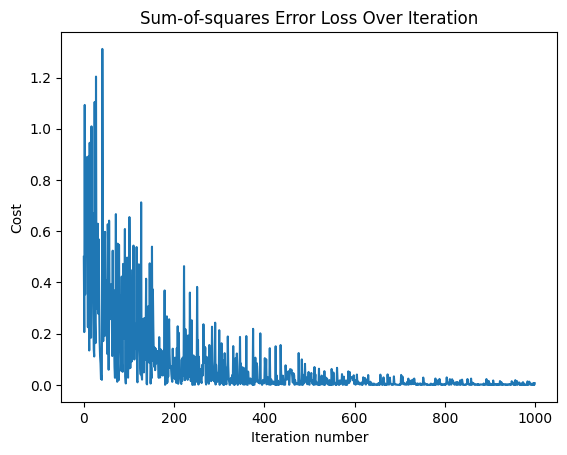

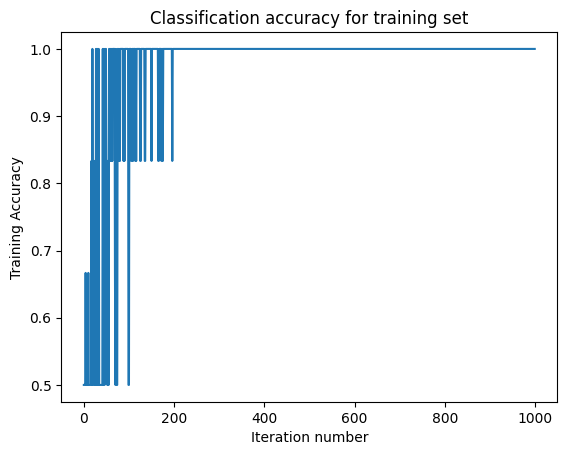

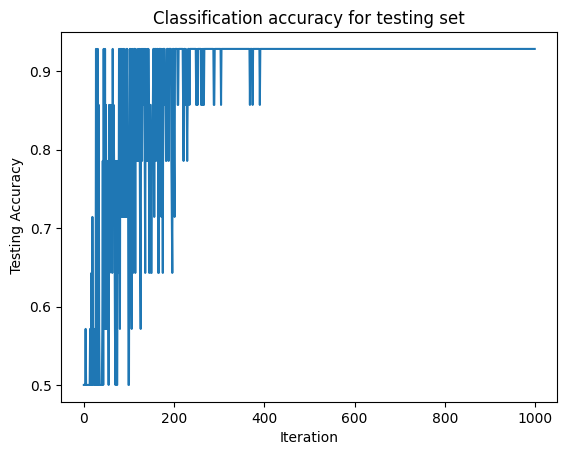

In [89]:
# Your code goes here

# find the indices of the samples for subject 1 and 30
subj1_ind = np.where(labels == 1)[0]
subj30_ind = np.where(labels == 30)[0]

# partition the data into training and testing sets or subject 1 and 30
n = 3
subj1_train_ind, subj1_test_ind = partition_data(labels[subj1_ind], num_per_class=n)
subj30_train_ind, subj30_test_ind = partition_data(labels[subj30_ind], num_per_class=n)

# concatenate the training and testing sets for subjects 1 and 30
train_idx = np.concatenate([subj1_ind[subj1_train_ind], subj30_ind[subj30_train_ind]])
test_idx = np.concatenate([subj1_ind[subj1_test_ind], subj30_ind[subj30_test_ind]])

# get the corresponding data and labels
train_data = data[train_idx, :]
train_labels = np.where(labels[train_idx] == 1, 1, -1)

test_data = data[test_idx, :]
test_labels = np.where(labels[test_idx] == 1, 1, -1)


# train and test the model
num_iter = 1000
learning_rate = 0.001
cost_all, w_all = lls_sgd_train(train_data, train_labels, num_iter, learning_rate)

train_pred = l2_rls_predict(w_all[-1], train_data) # Make predictions for the training set
train_acc = TestingAccuracy(train_pred, train_labels)
print("Training accuracy:", train_acc)

test_pred = l2_rls_predict(w_all[-1], test_data) # Make predictions for the test set
test_acc = TestingAccuracy(test_pred, test_labels)
print("Test accuracy:", test_acc)

# plot the cost over iterations
plt.plot(cost_all)
plt.title("Sum-of-squares Error Loss Over Iteration")
plt.xlabel("Iteration number")
plt.ylabel("Cost")
plt.show()

# plot the classification accuracy for the training set over iterations
train_acc_all = []
for i in range(len(w_all)):
    train_pred = l2_rls_predict(w_all[i], train_data)
    train_acc_all.append(TestingAccuracy(train_pred, train_labels))
plt.plot(train_acc_all)
plt.title("Classification accuracy for training set")
plt.xlabel("Iteration number")
plt.ylabel("Training Accuracy")
plt.show()

# plot the classification accuracy for the testing set over iterations
test_acc_all = []
for i in range(len(w_all)):
    test_pred = l2_rls_predict(w_all[i], test_data)
    test_acc_all.append(TestingAccuracy(test_pred, test_labels))
plt.plot(test_acc_all)
plt.title("Classification accuracy for testing set")
plt.xlabel("Iteration")
plt.ylabel(" Testing Accuracy")
plt.show()

### 7.3 Report

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

**Remember that all graphs should have axis labels and a title.**

### Option 2: Gradient descent training using hinge loss (7 marks, Hard)
Here is a recap of Hinge loss. For a single output model, the hinge loss over N training samples is $$O(\theta) = \sum^N_{i=1}\max\left(0, 1 - y_i f(\theta, x_i)\right)$$ where $y_i \in \{-1, +1\}$ is the class target label and $f(\theta, x_i)$ is your prediction function. While this is not directly differentiable, we can split it into two separately differentiable parts. For one sample, the above formuation is equivalent to:
$$
\max\left(0, 1 - y_i f(\theta, x_i)\right) = \begin{cases}
    0 & \text{if } y_i f(\theta, x_i) \geq 1 \\ % & is your "\tab"-like command (it's a tab alignment character)
    1-y_i f(\theta, x_i) & \text{otherwise.}
\end{cases}
$$

### 7.1 Implementation
Apply the gradient descent approach to train your classifier but by minimising the hinge loss. Implement the function `hinge_gd_train` below. 

`hinge_gd_train` trains a single-output linear model by minimising the hinge loss using the gradient descent approach. The optimisation function should include a regularisation term and regularisation hyperparameter $C$. It should take the iteration number $N$, the learning rate $\eta$, and regularisation hyperparameter $C$ as arguments. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of the regularised hinge loss model calculated in all the iterations.


### 7.2 Experiment design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference for gradient descent training based on the least squared loss and the hinge loss. 


### 7.3 Report

Explain in your report the following: 

(1) Your implementation of `hinge_gd_train`. If you analytically derived the loss function, please include it here.

(2) Your experiment design, comparative result analysis and interpretation of obtained results. 

**Remember that all graphs should have axis labels and a title.**